In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# =========================
# STEP 1: Load Data
# =========================
df = pd.read_csv(r"C:\Users\Wahid\Downloads\Housing (1).csv")

# Data Leakage Check
if 'price' not in df.columns:
    raise ValueError("\n[Check 1] Target column missing — Possible issue!")
else:
    print("\n[Check 1] Target column present: No leakage yet")

# =========================
# STEP 2: Outlier Capping
# =========================
price_upper = df['price'].quantile(0.99)
price_lower = df['price'].quantile(0.01)
df['price'] = np.clip(df['price'], price_lower, price_upper)

# price_per_sqft feature for capping
df['price_per_sqft'] = df['price'] / df['area']
upper_pps = df['price_per_sqft'].quantile(0.99)
lower_pps = df['price_per_sqft'].quantile(0.01)
df['price_per_sqft'] = np.clip(df['price_per_sqft'], lower_pps, upper_pps)

# =========================
# STEP 3: Train-Test Split
# =========================
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================
# STEP 4: Feature Engineering
# =========================
def feature_engineering(df_):
    df_ = df_.copy()

    # Categorical mapping
    text_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
                 'airconditioning', 'prefarea']
    for col in text_cols:
        if col in df_.columns:
            df_[col] = df_[col].map({'yes':1, 'no':0})

    if 'furnishingstatus' in df_.columns:
        df_['furnishingstatus'] = df_['furnishingstatus'].map({
            'unfurnished':0, 'semi-furnished':1, 'furnished':2
        })

    # Numeric features
    def safe_div(a, b):
        out = a / b
        return out.replace([np.inf, -np.inf], np.nan)

    if all(c in df_.columns for c in ['bathrooms','bedrooms']):
        df_['bath_bed_ratio'] = safe_div(df_['bathrooms'], df_['bedrooms'])
        df_['total_rooms'] = df_['bedrooms'] + df_['bathrooms']

    if 'area' in df_.columns:
        if 'bathrooms' in df_.columns:
            df_['bathroom_per_sqft'] = safe_div(df_['bathrooms'], df_['area'])
        if 'bedrooms' in df_.columns:
            df_['bedroom_per_sqft'] = safe_div(df_['bedrooms'], df_['area'])
        if all(c in df_.columns for c in ['bedrooms','bathrooms']):
            df_['total_rooms_sqft_ratio'] = safe_div(df_['bedrooms']+df_['bathrooms'], df_['area'])

    # Polynomial features (Linear Regression)
    for col in ['bedrooms','bathrooms','area']:
        if col in df_.columns:
            df_[col+'_sq'] = df_[col] ** 2

    return df_

X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

# =========================
# STEP 5: Pipelines with Imputer + Scaler + Log Target
# =========================
def TTR(model):
    return TransformedTargetRegressor(regressor=model, func=np.log1p, inverse_func=np.expm1)

pipelines = {
    'Linear Regression': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('regressor', TTR(LinearRegression()))
    ]),
    'Random Forest': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('regressor', TTR(RandomForestRegressor(
            n_estimators=300, max_depth=None, min_samples_leaf=2,
            max_features='sqrt', random_state=42
        )))
    ]),
    'Gradient Boosting': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('regressor', TTR(GradientBoostingRegressor(
            n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42
        )))
    ])
}

# =========================
# STEP 6 & 7: Fit + CV + Metrics
# =========================
model_performance = {}
for name, pipeline in pipelines.items():
    print(f"\nTraining {name}...")
    pipeline.fit(X_train, y_train)

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    y_pred = pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    model_performance[name] = {
        'R² Score (Test)': r2,
        'CV Mean R²': np.mean(cv_scores),
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }

    print(f"[Check 3] CV Mean R²: {np.mean(cv_scores):.4f}")
    print(f"R² Score (Test): {r2:.4f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

# =========================
# STEP 8: Best Model
# =========================
best_model_name = max(model_performance, key=lambda x: model_performance[x]['R² Score (Test)'])
best_metrics = model_performance[best_model_name]

print("\n" + "="*60)
print(f"Best Model: {best_model_name}")
print("="*60)
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

# =========================
# STEP 9: Feature Importance (Tree Models)
# =========================
if best_model_name in ['Random Forest','Gradient Boosting']:
    try:
        feature_importances = pipelines[best_model_name]['regressor'].regressor.feature_importances_
        fi_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
        fi_df = fi_df.sort_values('Importance', ascending=False)
        print("\n[Check 4] Top 10 Important Features:")
        print(fi_df.head(10))
    except:
        print("[Check 4] Feature importance not available.")

# =========================
# STEP 10: Overfitting Control
# =========================
train_r2 = pipelines[best_model_name].score(X_train, y_train)
test_r2 = pipelines[best_model_name].score(X_test, y_test)
print(f"\n[Check 5] Overfitting Check: Train R² = {train_r2:.4f}, Test R² = {test_r2:.4f}")
print(f"Gap = {abs(train_r2 - test_r2):.4f}")

# =========================
# STEP 11: Save Processed Data
# =========================
train_df = X_train.copy()
train_df['price'] = y_train
train_df.to_csv("processed_train.csv", index=False)

test_df = X_test.copy()
test_df['price'] = y_test
test_df.to_csv("processed_test.csv", index=False)

print("\n[Check 6] Processed train/test CSV files saved!")



[Check 1] Target column present: No leakage yet

Training Linear Regression...
[Check 3] CV Mean R²: 0.9409
R² Score (Test): 0.9486
MSE: 230928568761.93
RMSE: 480550.28
MAE: 321007.92

Training Random Forest...
[Check 3] CV Mean R²: 0.7772
R² Score (Test): 0.7804
MSE: 986465521348.40
RMSE: 993209.71
MAE: 702703.63

Training Gradient Boosting...
[Check 3] CV Mean R²: 0.9498
R² Score (Test): 0.9671
MSE: 147766553240.17
RMSE: 384404.15
MAE: 251859.71

Best Model: Gradient Boosting
R² Score (Test): 0.9671
CV Mean R²: 0.9498
MSE: 147766553240.1703
RMSE: 384404.1535
MAE: 251859.7084
[Check 4] Feature importance not available.

[Check 5] Overfitting Check: Train R² = 0.9966, Test R² = 0.9671
Gap = 0.0295

[Check 6] Processed train/test CSV files saved!


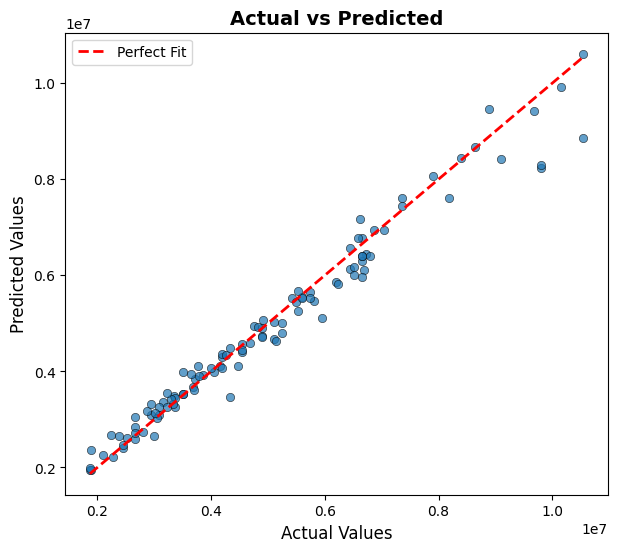

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: y_test, y_pred available hain
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, edgecolor="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label="Perfect Fit")
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.title("Actual vs Predicted", fontsize=14, fontweight="bold")
plt.legend()
plt.show()


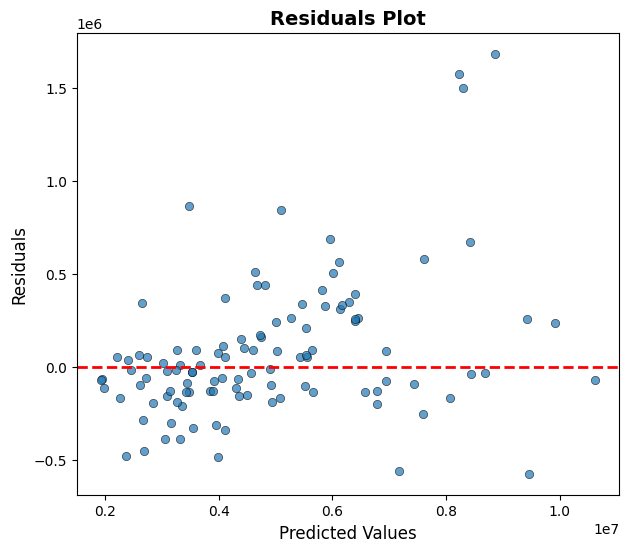

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred

plt.figure(figsize=(7,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.7, edgecolor="k")
plt.axhline(y=0, color="red", linestyle="--", lw=2)
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.title("Residuals Plot", fontsize=14, fontweight="bold")
plt.show()


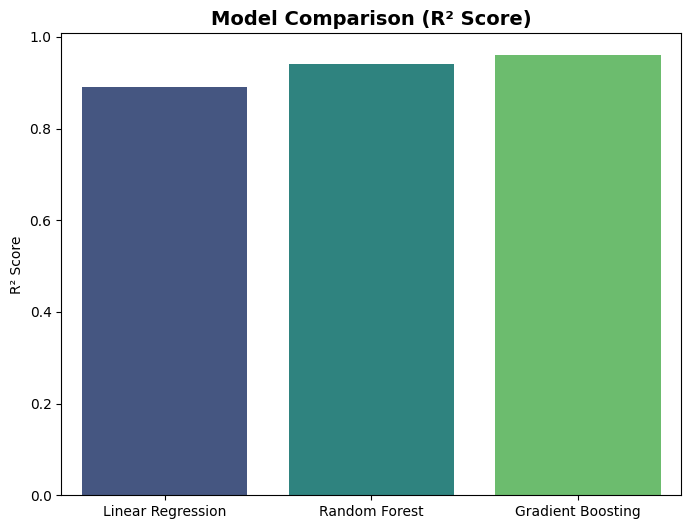

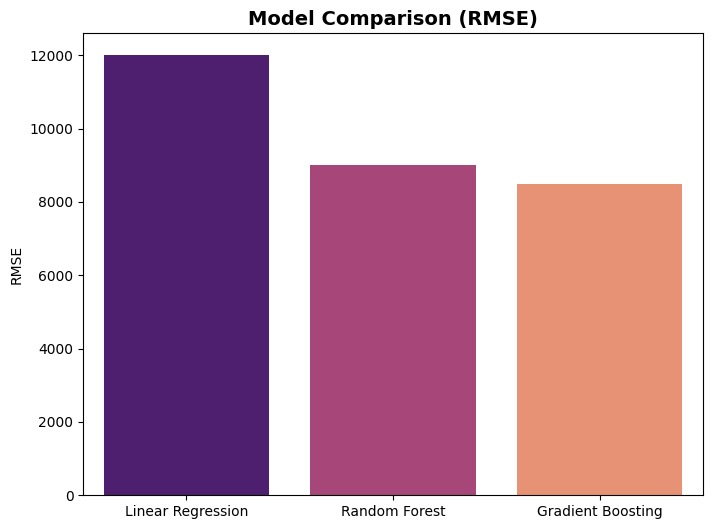

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

results = {
    "Linear Regression": {"r2":0.89, "rmse":12000},
    "Random Forest": {"r2":0.94, "rmse":9000},
    "Gradient Boosting": {"r2":0.96, "rmse":8500}
}

models = list(results.keys())
r2_scores = [results[m]["r2"] for m in models]
rmse_scores = [results[m]["rmse"] for m in models]

# R² Comparison
plt.figure(figsize=(8,6))
sns.barplot(x=models, y=r2_scores, palette="viridis")
plt.title("Model Comparison (R² Score)", fontsize=14, fontweight="bold")
plt.ylabel("R² Score")
plt.show()

# RMSE Comparison
plt.figure(figsize=(8,6))
sns.barplot(x=models, y=rmse_scores, palette="magma")
plt.title("Model Comparison (RMSE)", fontsize=14, fontweight="bold")
plt.ylabel("RMSE")
plt.show()


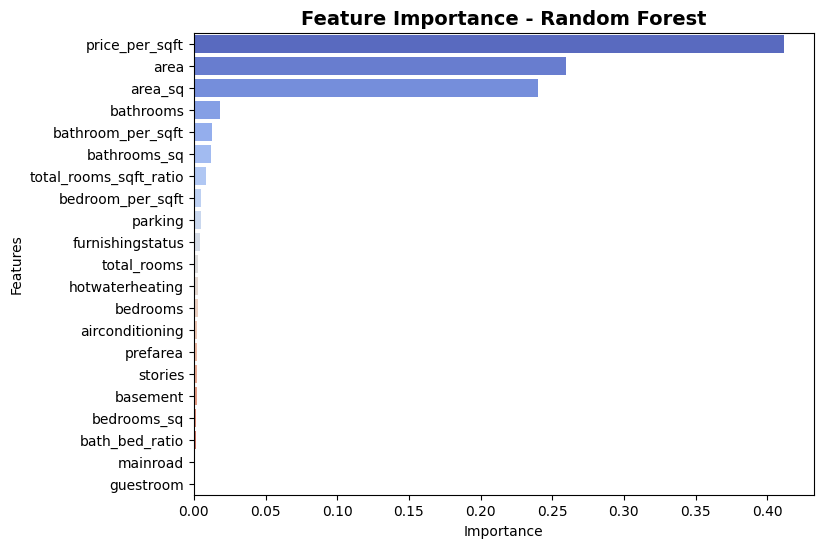

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example: RandomForest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor().fit(X_train, y_train)

importance = rf.feature_importances_
sorted_idx = np.argsort(importance)[::-1]

plt.figure(figsize=(8,6))
sns.barplot(x=importance[sorted_idx],
            y=np.array(X_train.columns)[sorted_idx],
            palette="coolwarm")
plt.title("Feature Importance - Random Forest", fontsize=14, fontweight="bold")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()
